# hcaptcha style distortions

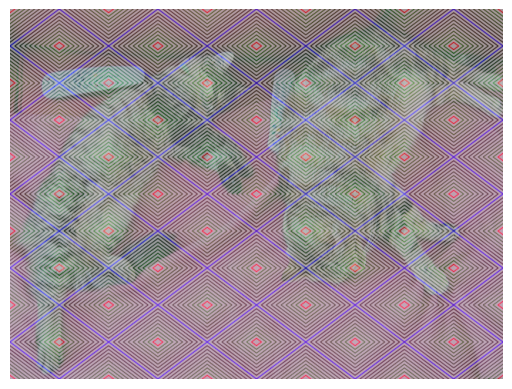

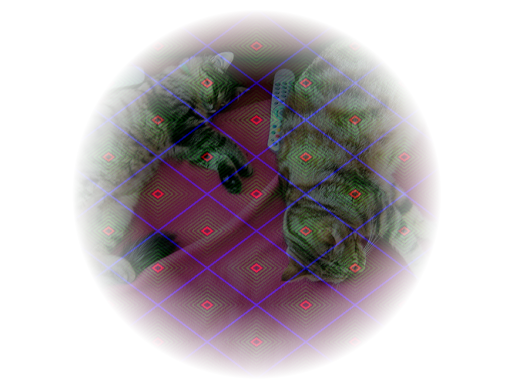

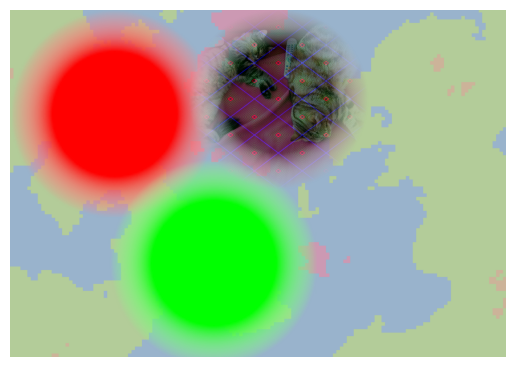

In [2]:
from advx.background import get_perlin_background
from advx.utils import get_rounded_corners, place_within, add_overlay
from advx.masks import get_diamond_mask
import matplotlib.pyplot as plt
from PIL import Image
import requests

background: Image.Image = get_perlin_background()


url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw).convert("RGBA")
img = add_overlay(img, get_diamond_mask(), 150)
plt.imshow(img)
plt.axis('off')
plt.show()

inner1: Image.Image = get_rounded_corners(Image.new("RGBA", (100, 100), (255, 0, 0, 255)))
inner2: Image.Image = get_rounded_corners(Image.new("RGBA", (100, 100), (0, 255, 0, 255)))
inner3: Image.Image = get_rounded_corners(img)
plt.imshow(inner3)
plt.axis('off')
plt.show()

result = place_within(background, inner1, inner_position=(0, 0))
result = place_within(result, inner2, inner_position=(200, 300))
result = place_within(result, inner3, inner_position=(300, 0))
plt.imshow(result)
plt.axis('off')
plt.show()

# chaining models

Generating an image...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

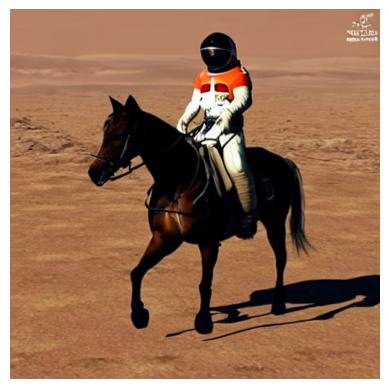

Captioning the image...


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


text_queries: ['a person', 'a horse', 'a dirt field']
Classifying the image...


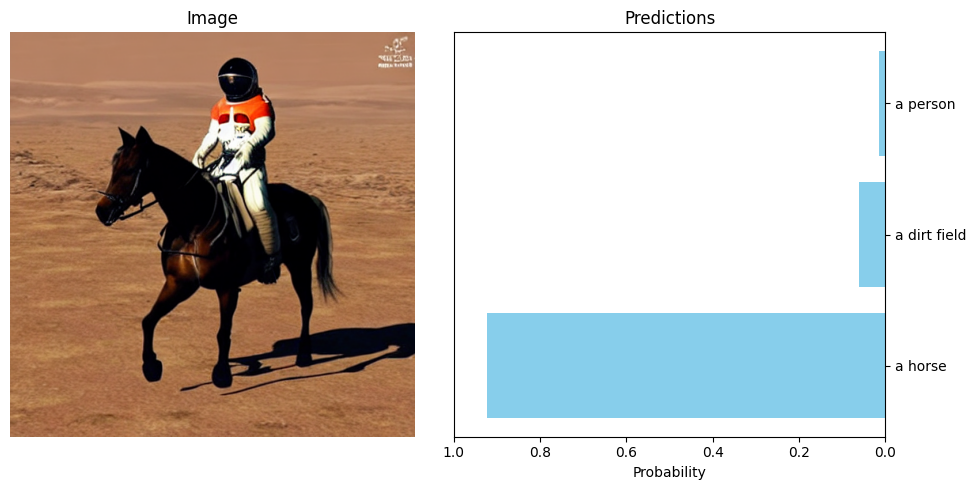

Detecting objects in the image...
Segmenting objects in the image...


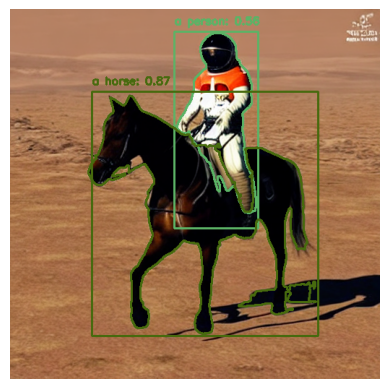

In [4]:
from matplotlib import pyplot as plt
from utils import set_seed
from models.generation import gen_stable_diffusion
from models.cls import classify_clip, plot_classification
from models.det import detect_vit
from models.seg import segment_sam1, plot_segmentation_detection
from models.caption import caption_gpt2


set_seed(42)

GREEN = "\033[92m"
RESET = "\033[0m"

# 1. generate an image
print(f"{GREEN}Generating an image...{RESET}")
img = gen_stable_diffusion("an austronaut on mars riding a horse")
plt.imshow(img)
plt.axis('off')
plt.show()

# 2. caption it
print(f"{GREEN}Captioning the image...{RESET}")
text_queries = caption_gpt2(img)
print("text_queries:", text_queries)

# 3. classify, detect, segment it
print(f"{GREEN}Classifying the image...{RESET}")
probs = classify_clip(img, text_queries)
plot_classification(img, text_queries, probs)

print(f"{GREEN}Detecting objects in the image...{RESET}")
threshold = 0.1
boxes, scores, labels = detect_vit(img, text_queries, threshold)

print(f"{GREEN}Segmenting objects in the image...{RESET}")
masks = segment_sam1(img, boxes)
plot_segmentation_detection(img, boxes, scores, text_queries, masks)
